## 6.1 Customer Segmentation

We can use a simple segmentation method such as RFM, which groups customers according to three metrics:
- **Recency**: How recently did the customer place the last order?
- **Frequency**: How often does the customer place orders?
- **Monetary value**: How much does the customer spend on average?
  
Afterward, each customer is assigned to a category according to its RFM scores. This segmentation process is particularly useful for personalized marketing or to improve customer service by addressing the specific needs of different customer groups.

The following SQL query is a bit longer than the previous but not too complex. I'll break it down in 3 steps:

**1.** Calculate each of the three RFM scores in three CTEs using the NTILE function, which ranks each customer from 1-5 in the given score.

**2.** Assign each customer to one of 11 groups.

**3.** Calculate statistics for each group, so we can plot them by sales, recency and size.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sqlite3
import pandas as pd
db_path = '/content/drive/MyDrive/E-Commerce DA/olist.sqlite'
db_connection = sqlite3.connect(db_path)

In [9]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH ScoreRecency AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
ScoreFrequency AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
ScoreMonetary AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group
RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Golden"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Losted"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyals"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "New Users"
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Next Loyalist"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Risong"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "Almost lost"
        END AS RFM_Bucket
    FROM ScoreRecency
        JOIN ScoreFrequency USING (customer_unique_id)
        JOIN ScoreMonetary USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket,
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase,
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""

df = pd.read_sql(rfm_buckets, db_connection)
df

,RFM_Bucket,avg_days_since_purchase,avg_sales_per_customer,customer_count
0,Almost lost,2522.080890,57.684959,7584
1,Attention,2523.137970,145.904925,6510
2,Can't Lose,2695.384199,350.886817,1723
3,Golden,2349.111456,250.856821,4607
4,Hibernating,2696.393876,182.845816,20288
5,Losted,2698.922654,57.393210,15331
6,Loyals,2479.576919,237.881257,9315
7,New Users,2347.484795,67.642129,5421
8,Next Loyalist,2406.272088,130.374773,18114
9,Risong,2439.225723,35.085359,2245


Let's visualize this. I'll plot each group using average recency on the x-axis, average sales per customer on the y-axis and circle size to represent the amount of customers in each group:

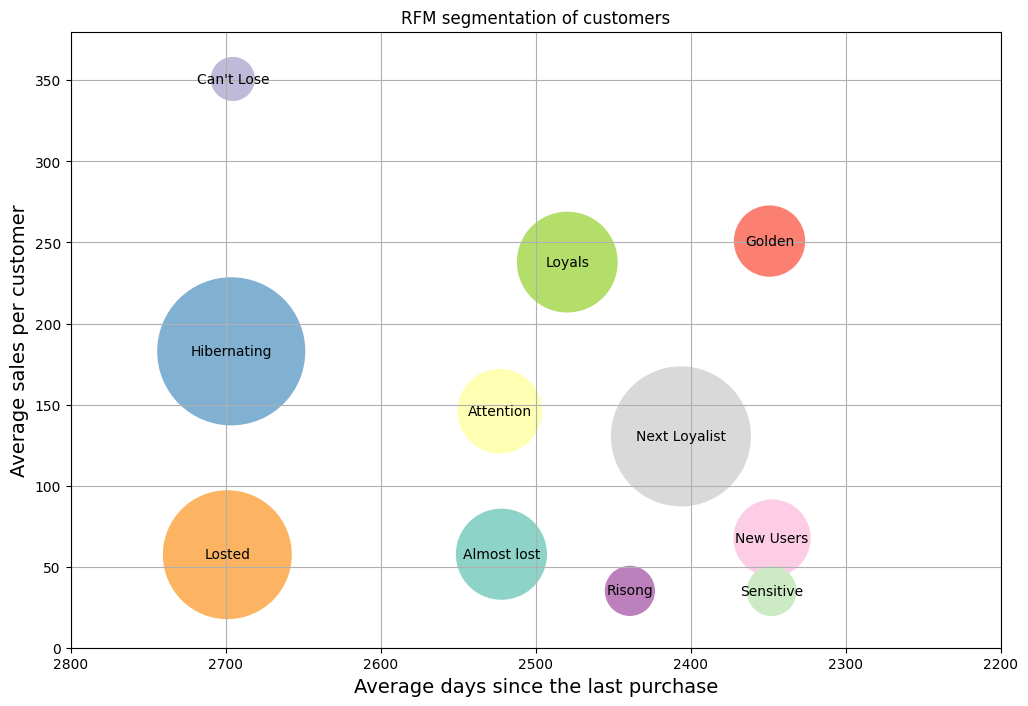

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['avg_days_since_purchase'], df['avg_sales_per_customer'],
    s=df['customer_count']*0.55, c=sns.color_palette('Set3', len(df)))
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM segmentation of customers')
plt.grid(True)
for i, text in enumerate(df['RFM_Bucket']):
    plt.annotate(text, (df['avg_days_since_purchase'][i], df['avg_sales_per_customer'][i]),
        ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim(2800, 2200)
plt.ylim(0, 380)
plt.show()

The previous plot shows us where each customer segment falls in terms of recency and sales. For example, the 'Golden' segment on the top right has high sales and has purchased recently, while the 'Losted' segment on the opposite side has low sales and no recent purchases.

## 6.2 Customer Porpotion

Let's build a plot of the proportion of one-time customers vs repeat customers to gain more insight into how loyal are people who buy through Olist:

In [11]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
)
SELECT
    CASE WHEN order_count > 1 THEN 'repeaters' ELSE 'one-time-buyers' END AS order_type,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM CustomerOrders), 1) AS proportion
FROM CustomerOrders
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

,order_type,proportion
0,one-time-buyers,96.9
1,repeaters,3.1


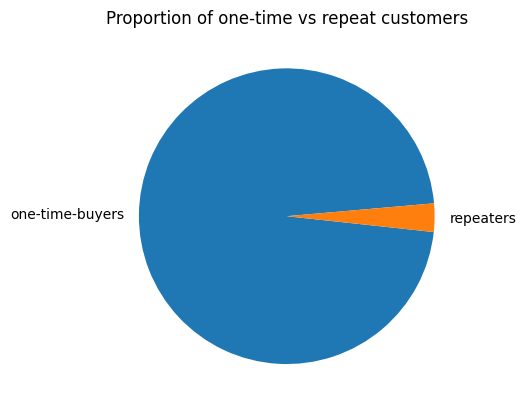

In [12]:
fig, ax = plt.subplots()
ax.pie(df['proportion'], labels=df['order_type'], startangle=5)
ax.set_title('Proportion of one-time vs repeat customers')
fig.set_facecolor('white')
plt.show()

As we can see most customers only place a single order.